
<center>PyPEF – an Integrated Framework for Data-driven Protein Engineering</center>
<br><center>Niklas E. Siedhoff<sup>1,§</sup>, Alexander-Maurice Illig<sup>1,§</sup>, Ulrich Schwaneberg<sup>1,2</sup>, Mehdi D. Davari<sup>1,*</sup></center></br>

<center><sup>1</sup>Institute of Biotechnology, RWTH Aachen University, Worringer Weg 3, 52074 Aachen, Germany</center>

<center><sup>2</sup>DWI-Leibniz Institute for Interactive Materials, Forckenbeckstraße 50, 52074 Aachen, Germany</center>

<center><sup>§</sup>Contributed equally to this work, <sup>∗</sup>Corresponding author</center>

<br><center>To be published</center></br>

### Machine learning-assisted protein engineering framework "PyPEF" 
PyPEF v. 0.1.2, December 2020
#### by Niklas Siedhoff and Alexander-Maurice Illig

## General Description

In the following, the reported version of the machine learning framework PyPEF is presented. The tool is written in Python 3 and inteded for executing it in command-line interpreters or exemplary **for running inside this Notebook, see [Running in Terminal](#Running-in-Terminal)** for testing the running commands. The code cells up to this section give a brief overview over the main programs functions. A general workflow of this tool is presented and described hereinafter (see Figure 1).

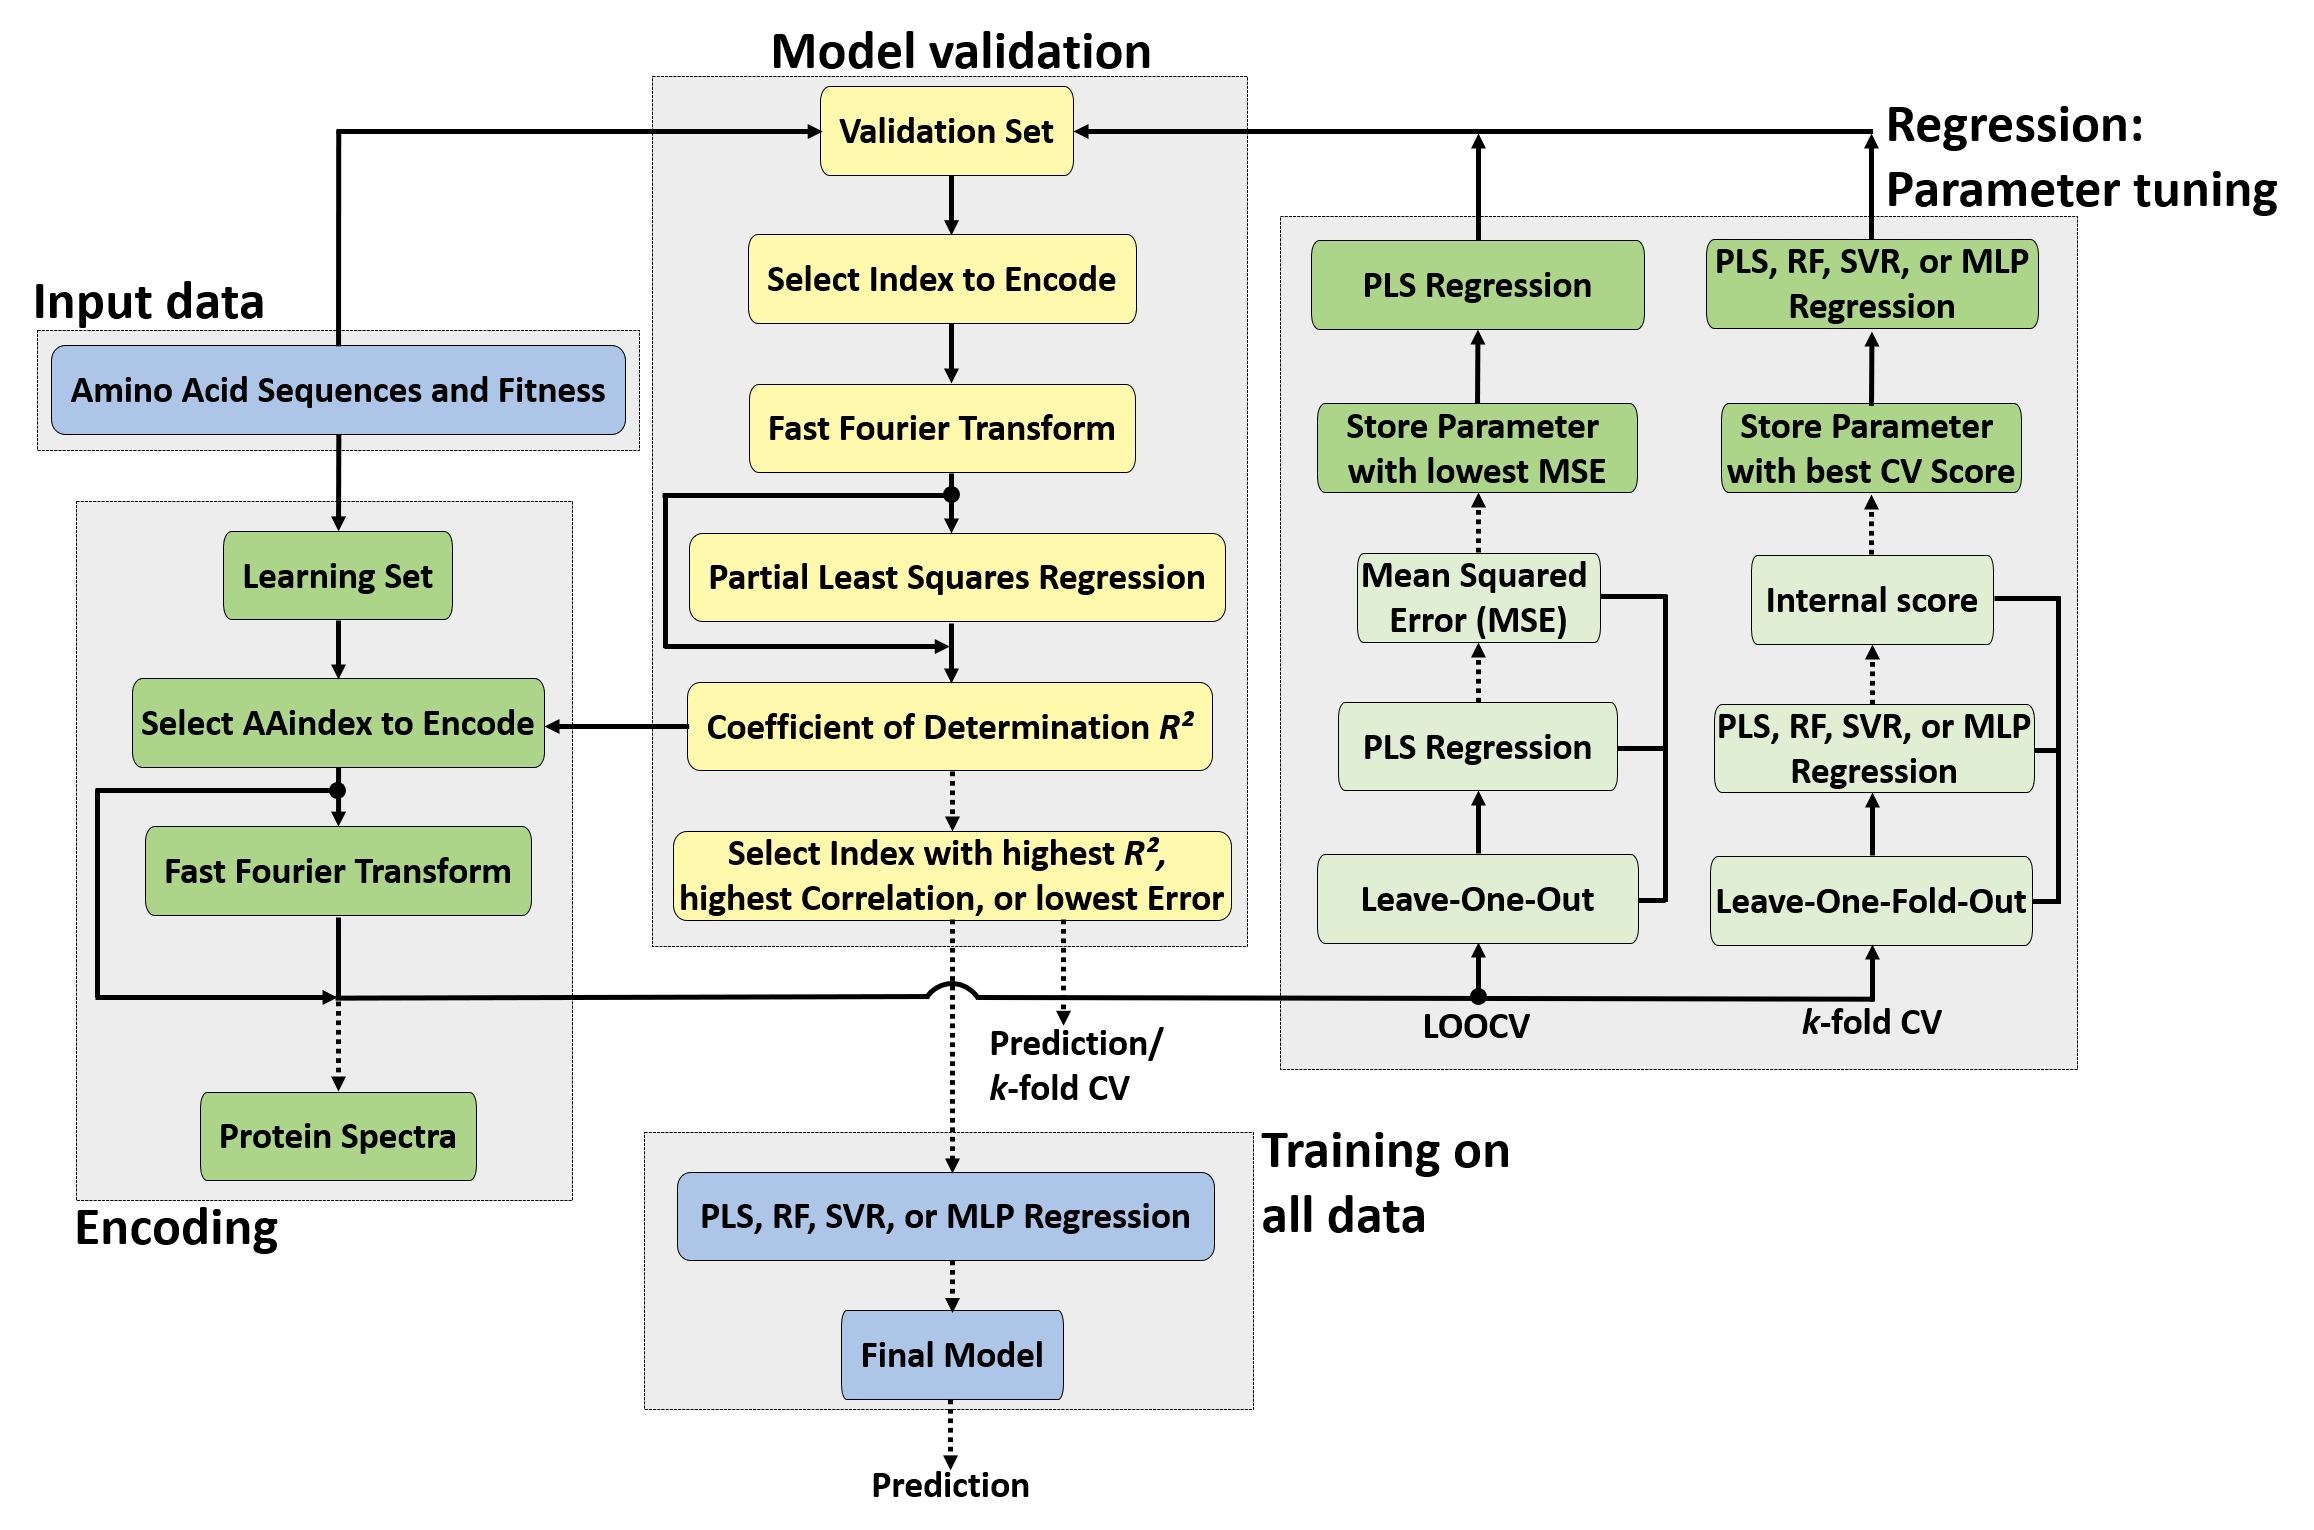
**Figure 1:** Schematic overview of the Regression-based algorithm: Blue components refer to the whole dataset size, yellow to the validation dataset and green to the learning dataset. Light green refers to the process of leave-one-out (LOOCV) or *k*-fold (CV) cross-validation (LOOCV) at which the learning dataset size is reduced by 1 or 1-fold, respectively.

PyPEF uses some regressors provided by the [scikit-learn](https://scikit-learn.org/stable/index.html) package. Tuning is performed either using the approach of Cadet *et al.* (leave-one-out cross validation and mean-squared error calculation for *N* component tuning) for PLS regression or else using a defined parameter grid and the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) module. 
PyPEF contains following encoding and regression options that can be defined by user arguments:
- Fourier transform of encoded sequences [default; optional: --nofft]
- Training/tuning of [PLS regressor](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) as proposed by Cadet et al. (LOOCV and MSE calculation) [default; --regressor pls]
- Training/tuning of PLS regressor using GridSearchCV (faster) [--regressor pls_cv]
- Training/tuning of [Random Forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using GridSearchCV [--regressor rf]
- Training/tuning of [Support Vector Machines regressor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) using GridSearchCV [--regressor svr]
- Training/tuning of [multilayer perceptron (MLP) regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (a deep learning model with feedforward deep network trained via backpropagation) using GridSearchCV [--regressor mlp]

The parameter grid for GridSearchCV was defined as follows:

In [ ]:
if regressor == 'pls':
    ... perform leave one out CV and choose N_components with lowest MSE

# other regression options (CV tuning)
elif regressor == 'pls_cv':
    params = {'n_components': list(np.arange(1, 10))}
    regressor_ = GridSearchCV(PLSRegression(), param_grid=params, iid=False, cv=5)  # iid in future
                                                                                    # versions redundant
elif regressor == 'rf':
    params = {                      # similar parameter grid as Xu et al., https://doi.org/10.1021/acs.jcim.0c00073
        'random_state': [42],
        'n_estimators': [100, 250, 500, 1000],  # number of individual decision trees in the forest
        'max_features': ['auto', 'sqrt', 'log2']  # “auto” -> max_features=n_features,
        # “sqrt” -> max_features=sqrt(n_features) “log2” -> max_features=log2(n_features)
    }
    regressor_ = GridSearchCV(RandomForestRegressor(), param_grid=params, iid=False, cv=5)

elif regressor == 'svr':
    params = {                      # similar parameter grid as Xu et al.
        'C': [2 ** 0, 2 ** 2, 2 ** 4, 2 ** 6, 2 ** 8, 2 ** 10, 2 ** 12],  # Regularization parameter
        'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]  # often 1 / n_features or 1 / (n_featrues * X.var())
    }
    regressor_ = GridSearchCV(SVR(), param_grid=params, iid=False, cv=5)

elif regressor == 'mlp':
    param_grid = {'hidden_layer_sizes': [i for i in range(1, 12)],
                  'activation': ['relu'],
                  'solver': ['adam', 'lbfgs'],
                  'learning_rate': ['constant'],  # learning rate given by ‘learning_rate_init’
                  'learning_rate_init': [0.001, 0.01, 0.1],  # only used when solver=’sgd’ or ‘adam’
                  'max_iter': [1000, 200],  # for stochastic solvers (‘sgd’, ‘adam’) determines epochs
                  'random_state': [42]
                  }
    regressor_ = GridSearchCV(MLPRegressor(), param_grid=param_grid, iid=False, cv=5)

The developed algorithm encompasses the automatized transformation of the given input sequences into numerical values using AAindex databank entries, default Fourier transform of the numerical sequences to protein spectra, (k-fold or leave-one-out) cross-validation for selecting the best model hyperparmeter, and consequently estimating model performance on a validation dataset. Besides, the model can also be generated without using FFT for processing of the sequence encoding.
Finally, the trained machine is used for estimating the fitness value of every given variant of length $N$, $N$ being the number of variant amino acids, in the unknown sequence space. The first step of the algorithm signifies the transformation of the given input sequences into numerical values. This conversion is performed for all entries of the AAindex database with the minimum availability of all 20 naturally encoded amino acids (a list of all 566 indices can be obtained from https://www.genome.jp/aaindex/AAindex/list_of_indices), so that the matrix $\mathbf{F} \in \mathbb{R}^{1 \times N}$ is established with $x_n$ being the value of the $n$-th entry:

$$ \mathbf{F} = \left(\begin{matrix} x_{0} & x_{1} & \dots & x_{N_{\mathrm{seq}-1}} \end{matrix}\right) $$

Each of the $N$ values is then normalized ($\tilde{x}$) following

$$ \tilde{x}_n = x_{n} - \overline{x} \ ,$$ 

with

$$ \overline{x} = \frac{1}{N} \sum_{n=0}^N x_n \ ,$$

so that artifacts of the Fourier transform can be avoided. The implemented fast Fourier transform (FFT) algorithm constraines $\mathbf{F} \in \mathbb{R}^{1 \times N_\mathrm{Dim}}$ to the condition

$$ N_\mathrm{Dim}\overset{!}{=}2^k, k \in \mathbb{N} \ .$$


If $N$ does not hold for the upper equation, $\mathbf{F}$ is reshaped by adding columns of zeros ("zero padding") until the condition is fulfilled. This normalized (and zero padded) matrix ($\mathbf{\tilde{F}}$) is then FFT-ed following

$$ \left|\hat{F}_j\right| = \left|\sum_{n=0}^{N_{\mathrm{Dim}}-1} \tilde{x}_{n} \exp \left( -\frac{2 \pi i j n}{N_{\mathrm{Dim}}} \right) \right| \ , \hat{F}_j \in \mathbb{C} \ , $$

with spectrum frequencies $j \in [0, 1, …, N_{\mathrm{Dim}}–1]$ and the imaginary number $i^2 = \, – 1$. A following plot of a normalized protein spectrum is presented in Figure 2. Since $\hat{F}_{N-j} = (\hat{F}_j)^*$, the FFT spectrum is mirrored at $0.5 \, j_{\mathrm{max}}$, as a result there is no need to use all frequencies for learning to obtain the saturated information content.

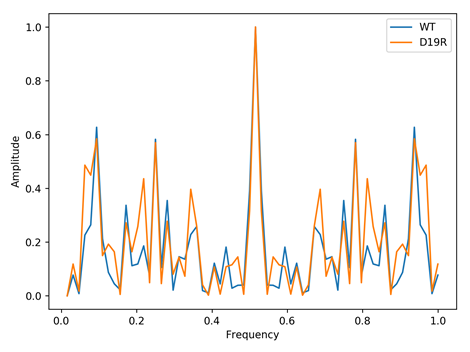

**Figure 2:** FFT protein spectra (of the peptide liquid chromatography peak I, LCI, wild-type (blue) and variant D19R (orange)). 

The spectrum amplitudes represent the independent variables and are used as input for the PLS regressor. $y$ is usually expressed as variant's (V) relative fitness value normalized to the wild-type (WT), i.e. $y = \frac{y_\mathrm{Variant}}{y_\mathrm{Wild-type}}$. The PLS regressor is fed with all except one input variant spectra when performing LOOCV parameter omptimization; else, regressors are trained on all data except the validation fold. Then, the trained regression model is used for predicting the label of the left-out variant(s). For $m$ given input sequences as learning dataset this process is performed  $\binom{m}{1} = m$ times for LOOCV and when using `GridSearchCV(cv=k)` $k$ times. For PLS regression (else GridSearchCV is used for tuning), for all predictions ($y$) of $y_\mathrm{true}$ building up the vector of the length $m$, the MSE is calculated following:

$$ \mathrm{MSE} =  \frac{1}{m} \sum_{i=1}^{m} (y_{\mathrm{obs},i} - y_{\mathrm{pred},i})^2 \ .$$   
    
The model hyperparameter ‘n_components’, the number of components in the PLS regression, is increased by 1 after every MSE loop up to ‘n_components’ reaching 10. An exemplary plot for the iteration of the number of components is shown in Figure 3. Here, the final model for the taken AAindex would be trained using 4 as the number of components for PLS regression.
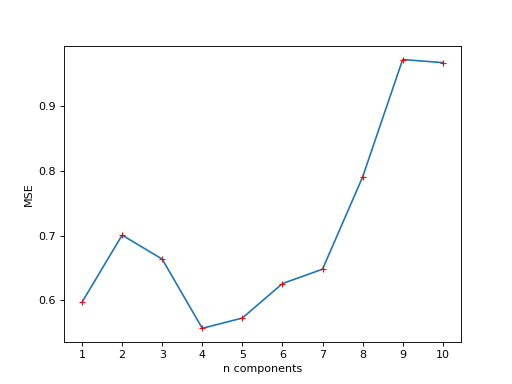

**Figure 3:** Exemplary plot of the mean-squared error for the iteration over the number of components for PLS regression.

For more information about estimating the number of components in PLS regression and the trade-off of overfitting and good predictions see other articles, e.g. <a href="https://www.sciencedirect.com/science/article/pii/0003267086800289" target="_blank">Link-1</a> and <a href="https://arxiv.org/pdf/1810.08104.pdf" target="_blank">Link-2</a>. For every AAindex, the model with the lowest MSE<sub>LOOCV</sub> is stored. The best performing numbers of components are used for training the 566 PLS regressors on the whole learning dataset (one variant more than in the LOOCV training dataset) and predicting the label of a given yet unseen validation dataset. For GridSearchCV parameter tuning, the scoring function of the used estimator, i.e. the `score` [method](https://scikit-learn.org/stable/modules/model_evaluation.html) of the regression type is used. The performance of these predictions are determined by calculating the $R^2$ score and prediction errors (RMSE, normalized RMSE (NRMSE)), as well as correlation (Pearson's $r$ and Spearman's rank correlation $\rho$) of the predicted observations ($y_\mathrm{pred}$) and the measured fitness values ($y_\mathrm{obs}$) following

$$ R^2 = \frac{\sum_{i=1}^{N} ({y_{\mathrm{pred},i} - \overline{y}_{\mathrm{obs}})^2}}{\sum_{i=1}^{N} ({y_{\mathrm{obs},i} - \overline{y}_{\mathrm{obs}}})^2} \ ,$$ 
and 
$$ RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_{\mathrm{obs},i} - y_{\mathrm{pred},i})^2} \ ,$$ 
while we defined the normalized RMSE (NRMSE) as normalized taking the sample standard deviation ($\sigma$) for division 
$$ NRMSE = \frac{RMSE}{\sigma} \ ,$$
with $$ \sigma = \sqrt{\frac{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}{N-1}} \ ,$$
respectively,
and the Pearson corellation coefficient $r$ being defined as
$$ r_\mathrm{Y_\mathrm{obs}, Y_\mathrm{pred}} = \frac{cov(Y_\mathrm{obs}, Y_\mathrm{pred})}{{\sigma_Y}_\mathrm{obs}{\sigma_Y}_\mathrm{pred}}
= \frac{\sum_{i=1}^{N}{(y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs})(y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred})}}
{\sqrt{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}
\sqrt{\sum_{i=1}^{N}({y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred}})^2}}
 \ ,$$
while we also implemented the study of rank corellation performance computing the Spearman rank correlation $\rho$
being the Pearson correlation coefficient between the ranks (instead of raw values),
where $N$ defines the number of variants in the validation set.

The user specifies a threshold for the number of saving the *s* best models according to the $R^2$ score on the validation dataset (also see [Cadet *et al.*](https://www.nature.com/articles/s41598-018-35033-y)). These *s* best models will be dumped as [pickle](https://docs.python.org/3/library/pickle.html) files and can easily be reloaded for predictions on new variants sequence space later on. After validation and optional viszualization of the measured and predicted observations (see Figure 4), the final model can optionally be trained on the whole dataset. An exemplary plot of a validation routine is shown hereinafter.

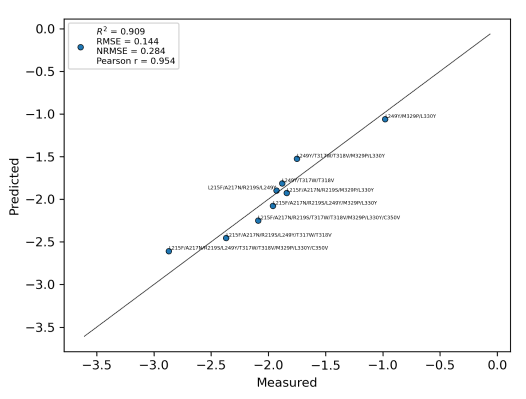

**Figure 4:** Validaton plot of predicted vs. measured entries of the validation dataset.

##### Performing predictions

Predictions using trained models can be performed on pure recombinant or natural diverse sequence data. However, as the sequence space to screen drastically increases for the number of simultaneously added mutation sites, we added the possiblity to explore the unknown variant space performing a random walk on diverse *in silico* directed evolution paths as described and presented by [Biswal *et al.*](https://www.biorxiv.org/content/10.1101/2020.01.23.917682v2); the corresponding code can be explored here: [GitHub repository](https://github.com/ivanjayapurna/low-n-protein-engineering) and exemplary [Jupyter Notebook](https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/directed-evo/DE_notebook.ipynb).

After randomly chosing and accepting a first mutation in a sequence, subsequently, substitutions will be added when meeting an update criterion that is defined by the Metropolis-Hastings algorithm. Here, the Metropolis choice for acception (when setting the Boltzmann constant $k$ to one) is defined as:
$$ A = min(1,exp(\frac{\Delta y_\mathrm{pred}}{T})) \ ,$$

with $T$ being the "Temperature" of the "Boltzmann-distributed" system and ($\Delta y_\mathrm{pred}$) being the difference ($y^*_\mathrm{pred} - y_\mathrm{pred}$) of the newly predicted ($^*$) sequence fitness and the fitness of the sequence variant predicted before, respectively.
If we plot $\Delta y_\mathrm{pred}$ against $exp(\frac{\Delta y_\mathrm{pred}}{T})$ we can see the influence of the Temperature on the acceptance ratio (see Figure 5).

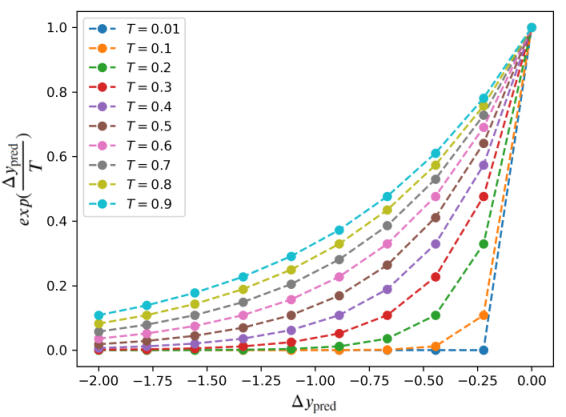

**Figure 5:** Influence of different temperatures on acceptance graph.

Then we randomly generate a number $u$ between 0 and 1 ($u \in [0,1]$). If $u \leq A$, the new state, that is the new sequence with $y^*_\mathrm{pred}$, gets accepted; else, i.e., if $u \gt A$, the new sequence will be rejected and the old will be kept. Instead of allowing more than a single substitution per iteration in evolution, we kept the number of introduced substitution per round at one.  

## Start of code explanantion
##### (only for Modules_Regression.py as this script contains the essential machine learning functions for feature encoding, learning, and validation)

### Section 1: Argument parsing and import of Modules
 The docstring of the program is used for argument parsing and thus necessary for running the commands.

In [ ]:
# Docstring essential for docopt arguments
"""
PyPEF - Pythonic Protein Engineering Framework.

Creation of Learning and Validation sets: To split .CSV data in Learning and Validation sets run
    pypef.py mklsvs [...]
Creation of Prediction sets: To create Prediction sets from .CSV data single point mutational variants run
    pypef.py mkps [...]
Running:
 1. To train and validate models run
        pypef.py run -l Learning_Set.fasta -v Validation_Set.fasta [-s 5] [--parallel] [-c 4]
    ! Attention using ray for parallel computing ('--parallel') in Windows: ray is not yet fully supported for Windows !
 2. To plot the validation creating a figure (.png) run
        pypef.py run -m MODEL12345 -f Validation_Set.fasta
 3. To predict variants run
        pypef.py run -m MODEL12345 -p Prediction_Set.fasta
    or for predicting variants in created prediction set folders exemplary run
        pypef.py run -m MODEL12345 --pmult [--drecomb] [...] [--qdiverse]
    or for performing in silico directed evolution run:
        pypef.py directevo -m MODEL12345 [...]


Usage:
    pypef.py mklsvs [--wtseq WT_SEQ] [--input CSV_FILE] [--drop THRESHOLD] [--nornd NUMBER]
    pypef.py mkps [--wtseq WT_SEQ] [--input CSV_FILE] [--drop THRESHOLD]
                                 [--drecomb] [--trecomb] [--qrecomb]
                                 [--ddiverse] [--tdiverse] [--qdiverse]
    pypef.py run --ls LEARNING_SET --vs VALIDATION_SET [--save NUMBER] [--regressor TYPE] [--nofft] [--sort METRIC]
                                                       [--parallel] [--cores NUMCORES]
    pypef.py --show [MODELS]
    pypef.py run --model MODEL12345 --figure VS_FOR_PLOTTING  [--label] [--color] [--ywt WT_FITNESS] [--nofft]
    pypef.py run --model MODEL12345 --ps PREDICTION_SET [--nofft] [--negative] [--print]
    pypef.py run --model MODEL12345 --pmult [--drecomb] [--trecomb] [--qrecomb]
                                          [--ddiverse] [--tdiverse] [--qdiverse] [--nofft] [--negative]
    pypef.py directevo --model MODEL12345 [--ywt WT_FITNESS] [--wtseq WT_SEQ]
                                        [--numiter NUM_ITER] [--numtraj NUM_TRAJ]
                                        [--temp TEMPERATURE] [--nofft] [--negative] [--print]
                                        [--usecsv] [--csvaa] [--input CSV_FILE] [--drop THRESHOLD]


Options:
  -h --help                    Show this screen.
  --version                    Show version.
  --show                       Show saved models in Model_Results.txt.
  MODELS                       Number of saved models to show [default: 5].
  -w --wtseq WT_SEQ            Input file (in .fa format) for Wild-Type sequence [default: None].
  -i --input CSV_FILE          Input data file in .csv format [default: None].
  -d --drop THRESHOLD          Below threshold variants will be discarded from the data [default: -9E09].
  -n --nornd NUMBER            Number of randomly created Learning and Validation datasets [default: 0].
  -s --save NUMBER             Number of Models to be saved as pickle files [default: 5].
  --parallel                   Parallel computing of training and validation of models [default: False].
  -c --cores NUMCORES          Number of cores used in parallel computing.
  --drecomb                    Create/predict double recombinants [default: False].
  --trecomb                    Create/predict triple recombinants [default: False].
  --qrecomb                    Create/predict quadruple recombinants [default: False].
  --ddiverse                   Create/predict double natural diverse variants [default: False].
  --tdiverse                   Create/predict triple natural diverse variants [default: False].
  --qdiverse                   Create quadruple natural diverse variants [default: False].
  -u --pmult                   Predict for all Prediction files in folder for recomb
                               or diverse variants [default: False].
  --negative                   Set if more negative values define better variants [default: False].
  -l --ls LEARNING_SET         Input Learning set in .fasta format.
  -v --vs VALIDATION_SET       Input Validation set in .fasta format.
  --regressor TYPE             Type of regression (R.) to use, options: PLS R.: pls, PLS CV R.: pls_cv, 
                               Random Forest R.: rf, SVM R.: svr, MLP R.: mlp [default: pls].
  --nofft                      Raw sequence input, i.e. no FFT for establishing protein spectra
                               as vector inputs [default: False].
  --sort METRIC                Rank models based on metric {1: R^2, 2: RMSE, 3: NRMSE, 4: Pearson's r,
                               5: Spearman's rank} [default: 1].
  -m --model MODEL12345        Model (pickle file) for plotting of Validation or for performing predictions.
  -f --figure VS_FOR_PLOTTING  Validation set for plotting using a trained Model.
  --label                      Label the plot instances [default: False].
  --color                      Color the plot for "true" and "false" predictions quarters [default: False].
  -p --ps PREDICTION_SET       Prediction set for performing predictions using a trained Model.
  --print                      Print raw encoded and FFT-ed sequence matrices and predictions in Shell [default: False].
  -y --ywt WT_FITNESS          Fitness value (y) of wild-type.
  --numiter NUM_ITER           Number of mutation iterations per evolution trajectory [default: 5].
  --numtraj NUM_TRAJ           Number of trajectories, i.e. evolution pathways [default: 5].
  --temp TEMPERATURE           "Temperature" of Metropolis-Hastings criterion [default: 0.01]
  --usecsv                     Perform directed evolution on single variant csv position data [default: False].
  --csvaa                      Directed evolution csv amino acid substitutions,
                               requires flag "--usecsv" [default: False].
"""

For performing the program routine, it is necessary to load some functions from the modules .py scripts.
All library requirements are listed in the <b>requirements.txt</b> file.
<ul>
<li>numpy==1.17.3</li>
<li>pandas==1.1.0</li>
<li>scikit-learn==0.21.3</li>
<li>scipy==1.3.1</li>
<li>matplotlib==3.1.1</li>
<li>docopt==0.6.2</li>
<li>tqdm==4.41.1</li>
<li>adjustText==0.7.3</li>
For parallel running:    
<li>ray==0.7.6</li>
<li>setproctitle==1.1.10</li>
<li>psutil==5.7.2</li>
</ul>

In [ ]:
# standard import, for all required modules see requirements.txt file(s)
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm import tqdm
from docopt import docopt
import multiprocessing
# import Modules_Parallelization.R2_List_Parallel locally to avoid error
# when not running in parallel, thus commented out:
# from Modules_Parallelization import R2_List_Parallel
# ray imported later locally as is is only used for parallelized running, thus commented out:
# import ray

# importing own modules
from Modules_Regression import read_models, Formatted_Output, R2_List, Save_Model, Predict, Predictions_Out, Plot
from Modules_Directed_Evolution import run_DE_trajectories
from Modules_Learning_Validation import (get_wt_sequence, csv_input, drop_rows, get_variants, make_sub_LS_VS,
                                         make_sub_LS_VS_randomly, make_fasta_LS_VS)
from Modules_Prediction import (Make_Combinations_Double, Make_Combinations_Triple, Make_Combinations_Quadruple,
                                create_split_files, Make_Combinations_Double_All_Diverse,
                                Make_Combinations_Triple_All_Diverse, Make_Combinations_Quadruple_All_Diverse)

Function `run()` then gets the arguments from docopts and runs diverse modules when the regarding flags have been put by the user following the scheme:

In [ ]:
# definition of run() function
def run():
    if user_argument_1:
        run func_1(x)
    elif user_argument_2:
        run func_2(y)
    elif user_argument_3:
        run func_3(z)
        
# execution of run() function
if __name__ == "__main__":
    run()

Here, docopts (http://docopt.org/) is used as argument parser which uses the docstring of the script itself for getting the argument commands and thus is used as parser for user-defined command-line arguments. NumPy (https://numpy.org/) is used for scientific computing (e.g. feature array handling). Scikit-learn (`sklearn`, https://scikit-learn.org/stable/index.html) is used for performing machine learning tasks, i.e. performing leave-one-out cross-validation (LOOCV, `LeaveOneOut`, or 5-fold cross validation using `GridSearchCV`), regression modeling, e.g. using partial-least-squares (PLS) regression (`PLSRegression`), and calculating the mean-squared-error (MSE, `mean_squared_error`) on the LOOCV data splits and finally for estimating the performance of the hyperparameter-tuned (PLS) regressor on the given validation set (e.g., the `r2_score`). For parallelization of independent iterative tasks of the program routine (the iteration over the number of components over all 566 entries of the AAindex), parallel running uses Ray (https://ray.readthedocs.io/en/latest/#) that supports Linux and MacOS (Windows support announced). Parallel running can be achieved by using the optional flags `--parallel -c` for specifying the number of CPUs to be used (for parallel running, by default, half of available cores/threads are used). 

Parallel running follows the run command, e.g. to use 4 cores you can define:
<br>`python3 pypef.py run -l LS.fasta -v VS.fasta -s 5 --parallel -c 4`
<br>In the following, mainly the non-parallelized version of this tool is described.

### Imported Modules from Modules_PLSR.py

To get a deeper insight into the program routine, the functions of each imported module (i.e. classes and functions) from Modules.py are shortly depicted in the following. For a more detailed description of each module see code. The program routine follows after description of the imported modules.

##### read_models
Function *read_models* just reads and prints the models found in the file *Model_Results.txt*. If no model was trained, the file does not exist.

In [ ]:
def read_models(number):
    """
    reads the models found in the file Model_Results.txt.
    If no model was trained, the .txt file does not exist.
    """
    try:
        ls = ""
        with open('Model_Results.txt', 'r') as file:
            for i, lines in enumerate(file):
                if i == 0:
                    if lines[:6] == 'No FFT':
                        number += 2
                if i <= number + 1:
                    ls += lines
        return ls
    except FileNotFoundError:
        return "No Model_Results.txt found."

##### Full_Path
Function *Full_Path* returns the path of an index inside the folder */AAindex/*, e.g. *path/to/AAindex/FAUJ880109.txt*.

In [ ]:
def Full_Path(Filename):
    """
    returns the path of an index inside the folder /AAindex/,
    e.g. path/to/AAindex/FAUJ880109.txt.
    """
    modules_path = os.path.dirname(os.path.abspath(__file__))
    return (os.path.join(modules_path, 'AAindex/'+Filename))

##### Path_AAindex_Dir
Function *Path_AAindex_Dir* returns the path to the */AAindex* folder, e.g. *path/to/AAindex/*.

In [ ]:
def Path_AAindex_Dir():
    """
    returns the path to the /AAindex folder, e.g. path/to/AAindex/.
    """
    return os.path.join(os.path.dirname(os.path.abspath(__file__)), 'AAindex')

##### AAindex
Class *AAindex* can be used to get all the information that are given in each AAindex file. For the program routine it provides the library to enable translation of the alphabetical amino acid sequence to an array of numericals.

In [ ]:
class AAindex:
    """
    gets all the information that are given in each AAindex file.
    For the program routine it provides the library to enable translation
    of the alphabetical amino acid sequence to an array of numericals.
    """
    def __init__(self, Filename):
        self.File = Filename
        self.Accession_Number = None
        self.Data_Description = None
        self.PMID = None
        self.Authors = None
        self.Title_Of_Article = None
        self.Journal_Reference = None

    def General_Information(self):
        """
        Gets and allocates general information based on the AAindex file
        format defined by file sections 'H', 'D', 'E', 'A', 'T', 'J'
        """
        with open(self.File, 'r') as f:
            for line in f:
                # try/ except "removes" empty lines.
                try:
                    words = line.split()
                    id_letter = words[0]
                except IndexError:
                    break

                # Extract some general information about AAindex file.
                if id_letter == 'H':
                    self.Accession_Number = words[1]
                elif id_letter == 'D':
                    self.Data_Description = words[1]
                elif id_letter == 'E':
                    self.PMID = words[1:]
                elif id_letter == 'A':
                    self.Authors = ' '.join(words[1:])
                elif id_letter == 'T':
                    self.Title_Of_Article = ' '.join(words[1:])
                elif id_letter == 'J':
                    self.Journal_Reference = ' '.join(words[1:])

    def Encoding_Dictionary(self):
        """
        Get numerical values of AAindex for each amino acid
        """
        with open(self.File, 'r') as f:
            for line in f:
                # try/ except "removes" empty lines
                try:
                    words = line.split()
                    id_letter = words[0]
                except IndexError:
                    break

                # Extract numerical values of AAindex.
                if id_letter == 'I':

                    Keys = []
                    for word in words[1:]:
                        Keys.append(word[0])
                        Keys.append(word[-1])

                    Values = []
                    for row in range(2):
                        line = f.readline()
                        strings = line.split()
                        for idx, string in enumerate(strings):
                            #Some Aminoacids may have no value.
                            try:
                                strings[idx] = float(string)
                            except ValueError:
                                strings[idx] = None
                        Values.append(strings)
                    Values = np.reshape(np.array(Values).T, len(Keys))

                    return dict(zip(Keys, Values))

##### Get_Sequences
The function *Get_Sequences* is used to read the given datasets, i.e. the learning and the validation dataset in FASTA format and it returns the name of the variant (`Name_Of_Mutation`), the sequence of the variant (`Sequence`), and the corresponding fitness value (i.e. relative fitness to wild-type, `Value`) in an array. An example of an appropriate input dataset is given below in the explanation of the [Program routine](#Program-Routine). For performing predictions (`Prediction=True`) no sequence label (`Values`, defined by lines starting with `';'`) is needed.

In [ ]:
def Get_Sequences(Fasta, Mult_Path=None, Prediction=False):
    """
    "Get_Sequences" reads (learning and validation).fasta format files and extracts the name,
    the target value and the sequence of the peptide. See example directory for required fasta file format.
    Make sure every marker (> and ;) is seperated by an space ' ' from the value/ name.
    """
    if Mult_Path is not None:
        os.chdir(Mult_Path)

    Sequences = []
    Values = []
    Names_Of_Mutations = []

    with open(Fasta, 'r') as f:
        for line in f:
            if '>' in line:
                words = line.split()
                Names_Of_Mutations.append(words[1])
                # words[1] is appended so make sure there is a space in between > and the name!

            elif '#' in line:
                pass  # are Comments

            elif ';' in line:
                words = line.split()
                Values.append(float(words[1]))
                # words[1] is appended so make sure there is a space in between ; and the value!

            else:
                try:
                    words = line.split()
                    Sequences.append(words[0])
                except IndexError:
                    raise IndexError("Learning or Validation sets (.fasta) likely have emtpy lines at end of file")

    # Check consistency
    if Prediction == False:
        if len(Sequences) != len(Values):
            print('Error: Number of sequences does not fit with number of target values!')
            print('Number of sequences: {}, Number of target values: {}.'.format(str(len(Sequences)), str(len(Values))))
            sys.exit()

    return Sequences, Names_Of_Mutations, Values

##### XY
The Class *XY* is used for 

- converting the string sequence into a list of numericals using the AAindex translation library,
- Fourier transforming the numerical array that was translated by *Get_Numerical_Sequence* (*Do_Fourier*),
- computing the input matrices $X$ and $Y$ for the regressors (*Get_X_And_Y*), or also returns raw encoded sequence matrix as feature option

In [ ]:
class XY:
    """
    converts the string sequence into a list of numericals using the AAindex translation library,
    Fourier transforming the numerical array that was translated by Get_Numerical_Sequence (Do_Fourier),
    computing the input matrices X and Y for the PLS regressor (Get_X_And_Y). Returns FFT-ed arrays (X),
    labels array (Y), and raw_encoded sequences arrays (raw_numerical_sequences)
    """
    def __init__(self, AAindex_File, Fasta_File, Mult_Path=None, Prediction=False):
        aaidx = AAindex(AAindex_File)
        self.dictionary = aaidx.Encoding_Dictionary()
        self.sequences, self.names, self.values = Get_Sequences(Fasta_File, Mult_Path, Prediction)

    def Get_Numerical_Sequence(self, Sequence):
        return (np.array([self.dictionary[aminoacid] for aminoacid in Sequence]))

    def Do_Fourier(self, Sequence):
        """
        This function does the Fast Fourier Transform. Since the condition

                    len(Array) = 2^k -> k = log_2(len(Array))
                    k in N

        must be satisfied, the array must be reshaped (zero padding) if k is no integer value.
        The verbose parameter prints also the real and imaginary part separately.
        """
        threshold = 1e-8  # errors due to computer uncertainties
        k = np.log2(Sequence.size)  # get exponent k
        Mean = np.mean(Sequence, axis=0)  # calculate mean of numerical array
        Sequence = np.subtract(Sequence, Mean)  # subtract mean to avoid artificial effects of FT

        if abs(int(k) - k) > threshold:  # check if length of array fulfills previous equation
            Numerical_Sequence_Reshaped = np.zeros(pow(2, (int(k) + 1)))  # reshape array
            for index, value in enumerate(Sequence):
                Numerical_Sequence_Reshaped[index] = value
            Sequence = Numerical_Sequence_Reshaped

        Fourier_Transformed = np.fft.fft(Sequence)  # FFT
        FT_real = np.real(Fourier_Transformed)
        FT_imag = np.imag(Fourier_Transformed)

        x = np.linspace(1, Sequence.size, Sequence.size)  # frequencies
        x = x / max(x)  # normalization of frequency

        Amplitude = FT_real * FT_real + FT_imag * FT_imag

        if max(Amplitude) != 0:
            Amplitude = np.true_divide(Amplitude, max(Amplitude))  # normalization of amplitude

        return Amplitude, x

    def Get_X_And_Y(self):
        """
        getting the input matrices X (FFT amplitudes) and Y (variant labels)
        """
        Frequencies = []
        Amplitudes = []
        raw_numerical_seq = []

        for sequence in self.sequences:
            num = self.Get_Numerical_Sequence(sequence)

            # There may be amino acids without a value in AAindex.
            # Skip these Indices.
            if None in num:
                break

            # Numerical sequence gets expended by zeros so that also different lengths of sequences
            # can be processed using '--nofft' option
            k = np.log2(len(num))
            if abs(int(k) - k) > 1e-8:  # check if length of array fulfills previous equation
                num_appended = np.append(num, np.zeros(pow(2, (int(k) + 1)) - len(num)))  # reshape array
            else:
                num_appended = num

            amplitudes, frequencies = self.Do_Fourier(num)

            # Fourier spectra are mirrored at frequency = 0.5. No more information at higher frequencies.
            half = len(frequencies) // 2  # // for integer division
            Frequencies.append(frequencies[:half])
            Amplitudes.append(amplitudes[:half])    # FFT-ed encoded amino acid sequences
            raw_numerical_seq.append(num_appended)  # Raw encoded amino acid sequences

        Amplitudes = np.array(Amplitudes)
        Frequencies = np.array(Frequencies)  # not used
        raw_numerical_seq = np.array(raw_numerical_seq)

        X = Amplitudes
        Y = self.values                             # Fitness values (sequence labels)

        return X, Y, raw_numerical_seq

##### Get_R2
The function *Get_R2* takes features and labels from the learning and validation set. The MSE is calculated for all LOOCV sets for predicted vs true labels  (`mse = mean_squared_error(y_test_loo, y_pred_loo`) for a fixed number of components for PLS regression. In the next iteration, the number of components is increased by 1 (`number_of_components += 1`) and the MSE is calculated for this regressor. The loop breaks if `i > 10`. Finally, the model of the single AAindex model with the lowest MSE is chosen:

`idx = np.where(Mean_Squared_Error == np.min(Mean_Squared_Error))[0][0] + 1`;

`pls = PLSRegression(n_components=idx)`.

When using other regressors the parameters are tuned using GridSearchCV:

- `'rf'`: RandomForestRegressor(best_params)
- `'svr'`: SVR(best_params)
- `'mlp'`: MLPRegressor(best_params)

The function returns the $R^2$, the (N)RMSE, and the Pearson's $r$ and Spearman's $\rho$ of the model. 

In [ ]:
def Get_R2(X_learn, X_valid, Y_learn, Y_valid, regressor='pls'):
    """
    The function Get_R2 takes features and labels from the learning and validation set.

    When using 'pls' as regressor, the MSE is calculated for all LOOCV sets for predicted vs true labels
    (mse = mean_squared_error(y_test_loo, y_pred_loo) for a fixed number of components for PLS regression.
    In the next iteration, the number of components is increased by 1 (number_of_components += 1)
    and the MSE is calculated for this regressor. The loop breaks if i > 9.
    Finally, the model of the single AAindex model with the lowest MSE is chosen.

    When using other regressors the parameters are tuned using GridSearchCV.

    This function returnes performance (R2, (N)RMSE, Pearson's r) and model parameters.
    """
    regressor = regressor.lower()
    Mean_Squared_Error = []

    if regressor == 'pls':
        # PLS regression as used by Cadet et al.
        # https://doi.org/10.1186/s12859-018-2407-8
        # https://doi.org/10.1038/s41598-018-35033-y
        # Hyperparameter (N component) tuning of PLS regressor
        for n_comp in range(1, 10):
            pls = PLSRegression(n_components=n_comp)
            loo = LeaveOneOut()

            y_pred_loo = []
            y_test_loo = []

            for train, test in loo.split(X_learn):
                x_learn_loo = []
                y_learn_loo = []
                x_test_loo = []

                for j in train:
                    x_learn_loo.append(X_learn[j])
                    y_learn_loo.append(Y_learn[j])

                for k in test:
                    x_test_loo.append(X_learn[k])
                    y_test_loo.append(Y_learn[k])

                pls.fit(x_learn_loo, y_learn_loo)
                y_pred_loo.append(pls.predict(x_test_loo)[0][0])

            mse = mean_squared_error(y_test_loo, y_pred_loo)

            Mean_Squared_Error.append(mse)

        Mean_Squared_Error = np.array(Mean_Squared_Error)
        idx = np.where(Mean_Squared_Error == np.min(Mean_Squared_Error))[0][0] + 1  # finds best number of components

        # Model is fitted with best n_components (lowest MSE)
        best_params = {'n_components': idx}
        regressor_ = PLSRegression(n_components=best_params.get('n_components'))

    # other regression options (CV tuning)
    elif regressor == 'pls_cv':
        params = {'n_components': list(np.arange(1, 10))}
        regressor_ = GridSearchCV(PLSRegression(), param_grid=params, iid=False, cv=5)  # iid in future
                                                                                        # versions redundant
    elif regressor == 'rf':
        params = {                      # similar parameter grid as Xu et al., https://doi.org/10.1021/acs.jcim.0c00073
            'random_state': [42],
            'n_estimators': [100, 250, 500, 1000],  # number of individual decision trees in the forest
            'max_features': ['auto', 'sqrt', 'log2']  # “auto” -> max_features=n_features,
            # “sqrt” -> max_features=sqrt(n_features) “log2” -> max_features=log2(n_features)
        }
        regressor_ = GridSearchCV(RandomForestRegressor(), param_grid=params, iid=False, cv=5)

    elif regressor == 'svr':
        params = {                      # similar parameter grid as Xu et al.
            'C': [2 ** 0, 2 ** 2, 2 ** 4, 2 ** 6, 2 ** 8, 2 ** 10, 2 ** 12],  # Regularization parameter
            'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]  # often 1 / n_features or 1 / (n_featrues * X.var())
        }
        regressor_ = GridSearchCV(SVR(), param_grid=params, iid=False, cv=5)

    elif regressor == 'mlp':
        param_grid = {'hidden_layer_sizes': [i for i in range(1, 12)],
                      'activation': ['relu'],
                      'solver': ['adam', 'lbfgs'],
                      'learning_rate': ['constant'],  # learning rate given by ‘learning_rate_init’
                      'learning_rate_init': [0.001, 0.01, 0.1],  # only used when solver=’sgd’ or ‘adam’
                      'max_iter': [1000, 200],  # for stochastic solvers (‘sgd’, ‘adam’) determines epochs
                      'random_state': [42]
                      }
        regressor_ = GridSearchCV(MLPRegressor(), param_grid=param_grid, iid=False, cv=5)

    else:
        raise SystemError("Did not find specified regression model as valid option. See '--help' for valid "
                          "regression model options.")

    regressor_.fit(X_learn, Y_learn)  # fit model

    if regressor != 'pls':      # take best parameters for the regressor and the AAindex
        best_params = regressor_.best_params_

    Y_pred = []
    for y_p in regressor_.predict(X_valid):  # predict validation entries with fitted model
        Y_pred.append(float(y_p))

    R2 = r2_score(Y_valid, Y_pred)
    RMSE = np.sqrt(mean_squared_error(Y_valid, Y_pred))
    NRMSE = RMSE / np.std(Y_valid, ddof=1)
    # ranks for Spearman's rank correlation
    Yval_rank = np.array(Y_valid).argsort().argsort()
    Ypred_rank = np.array(Y_pred).argsort().argsort()
    with warnings.catch_warnings():  # catching RunTime warning when there's no variance in an array, e.g. [2, 2, 2, 2]
        warnings.simplefilter("ignore")  # which would mean divide by zero
        pearson_r = np.corrcoef(Y_valid, Y_pred)[0][1]
        spearman_rho = np.corrcoef(Yval_rank, Ypred_rank)[0][1]

    return R2, RMSE, NRMSE, pearson_r, spearman_rho, regressor, best_params

##### R2_List
Function *R2_List* returns the sorted list of all the model number of components and the performance metrics values from function *Get_R2*. The user can define the metric for sorting (flag --sort INT_METRIC). 

In [ ]:
def R2_List(Learning_Set, Validation_Set, regressor='pls', noFFT=False, sort='1'):
    """
    returns the sorted list of all the model parameters and
    the performance values (R2 etc.) from function Get_R2.
    """
    AAindices = [file for file in os.listdir(Path_AAindex_Dir()) if file.endswith('.txt')]

    AAindex_R2_List = []
    for index, aaindex in enumerate(tqdm(AAindices)):
        xy_learn = XY(Full_Path(aaindex), Learning_Set)
        if noFFT == False:  # X is FFT-ed of encoded alphabetical sequence
            x_learn, y_learn, _ = xy_learn.Get_X_And_Y()
        else:               # X is raw encoded of alphabetical sequence
            _, y_learn, x_learn = xy_learn.Get_X_And_Y()

        # If x_learn (or y_learn) is an empty array, the sequence could not be encoded,
        # because of NoneType value. -> Skip
        if len(x_learn) != 0:
            xy_test = XY(Full_Path(aaindex), Validation_Set)
            if noFFT == False:  # X is FFT-ed of the encoded alphabetical sequence
                x_test, y_test, _ = xy_test.Get_X_And_Y()
            else:               # X is the raw encoded of alphabetical sequence
                _, y_test, x_test = xy_test.Get_X_And_Y()
            r2, rmse, nrmse, pearson_r, spearman_rho, regression_model, params = Get_R2(x_learn, x_test, y_learn,
                                                                                        y_test, regressor
                                                                                        )
            AAindex_R2_List.append([aaindex, r2, rmse, nrmse, pearson_r, spearman_rho, regression_model, params])

    try:
        sort = int(sort)
        if sort == 2 or sort == 3:
            AAindex_R2_List.sort(key=lambda x: x[sort])
        else:
            AAindex_R2_List.sort(key=lambda x: x[sort], reverse=True)

    except ValueError:
        raise ValueError("Choose between options 1 to 5 (R2, RMSE, NRMSE, Pearson's r, Spearman's rho.")

    return AAindex_R2_List

##### Formatted_Output
Function *Formatted_Output* takes the sorted list from function *R2_List* and writes the model names (indices) with an $R^2 \geq 0$ as well as the corresponding number of components for each model as well as perfromance metrices ($R^2$, prediction errors, and correlation) so that the user gets a list (*Model_Results.txt*) of the top ranking models for the given validation set. 

In [ ]:
def Formatted_Output(AAindex_R2_List, noFFT=False, Minimum_R2=0.0):
    """
    takes the sorted list from function R2_List and writes the model names with an R2 ≥ 0
    as well as the corresponding parameters for each model so that the user gets
    a list (Model_Results.txt) of the top ranking models for the given validation set.
    """

    index, value, value2, value3, value4, value5, regression_model, params = [], [], [], [], [], [], [], []

    for (idx, val, val2, val3, val4, val5, r_m, pam) in AAindex_R2_List:
        if val >= Minimum_R2:
            index.append(idx[:-4])
            value.append('{:f}'.format(val))
            value2.append('{:f}'.format(val2))
            value3.append('{:f}'.format(val3))
            value4.append('{:f}'.format(val4))
            value5.append('{:f}'.format(val5))
            regression_model.append(r_m.upper())
            params.append(pam)

    if len(value) == 0:  # Criterion of not finding suitable model is defined by Minimum_R2
        raise ValueError('No model with positive R2.')

    data = np.array([index, value, value2, value3, value4, value5, regression_model, params]).T
    col_width = max(len(str(value)) for row in data for value in row[:-1]) + 5

    head = ['Index', 'R2', 'RMSE', 'NRMSE', 'Pearson\'s r', 'Spearman\'s rho', 'Regression', 'Model parameters']
    with open('Model_Results.txt', 'w') as f:
        if noFFT is not False:
            f.write("No FFT used in this model construction, performance"
                    " represents model accuracies on raw encoded sequence data.\n\n")

        heading = "".join(caption.ljust(col_width) for caption in head) + '\n'
        f.write(heading)

        row_length = []
        for row in data:
            row_ = "".join(str(value).ljust(col_width) for value in row) + '\n'
            row_length.append(len(row_))
        row_length_max = max(row_length)
        f.write(row_length_max * '-' + '\n')

        for row in data:
            f.write("".join(str(value).ljust(col_width) for value in row) + '\n')

    return ()

##### cross_validation
Function *cross_validation* performs $k$-fold dataset splitting (while $k$ is set to 5). Taken from function *Save_Model*.

In [ ]:
def cross_validation(X, Y, regressor_, n_samples=5):
    # perform k-fold cross-validation on all data
    # k = Number of splits, change for changing k in k-fold split-up, default=5
    Y_test_total = []
    Y_predicted_total = []

    kf = KFold(n_splits=n_samples, shuffle=True)
    for train_index, test_index in kf.split(Y):
        Y = np.array(Y)
        try:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            for numbers in Y_test:
                Y_test_total.append(numbers)
            regressor_.fit(X_train, Y_train)  # Fitting on a random subset for Final_Model
            # (and on a subset subset for Learning_Model)
            # Predictions for samples in the test_set during that iteration
            pred_for_test_set_samples = regressor_.predict(X[test_index])
            for values in pred_for_test_set_samples:
                Y_predicted_total.append(float(values))
        except UserWarning:
            continue

    return Y_test_total, Y_predicted_total

##### Save_Model
Function *Save_Model* saves the best `-s THRESHOLD` models as 'Pickle' files (`pickle.dump`), which can be loaded again for doing predictions. Also, in *Save_Model* included is the computing of the $k$-fold CV performance of the n component-optimized model on all data (learning + validation set); by default $k$ is 5 (`n_samples = 5` in above function `cross_validation`). Plots and a results text file of the CV performance for the *s* best models are stored inside the folder *CV_performance*. Low performance (high errors) for CV are a sign of model overfitting. If flag '--all' is set (to True), the  final model that will be saved as 'Pickle' file will be trained on all data (learning + validation set).

In [ ]:
def Save_Model(Path, AAindex_R2_List, Learning_Set, Validation_Set, Threshold=5, regressor='pls',
               noFFT=False, all=False):
    """
    Function Save_Model saves the best -s THRESHOLD models as 'Pickle' files (pickle.dump),
    which can be loaded again for doing predictions. Also, in Save_Model included is the def cross_validation
    -based computing of the k-fold CV performance of the n component-optimized model on all data
    (learning + validation set); by default  k  is 5 (n_samples = 5).
    Plots of the CV performance for the t best models are stored inside the folder CV_performance.
    """
    regressor = regressor.lower()
    try:
        os.mkdir('CV_performance')
    except FileExistsError:
        pass
    try:
        os.mkdir('Pickles')
    except FileExistsError:
        pass

    try:
        os.remove('CV_performance/_CV_Results.txt')
    except FileNotFoundError:
        pass
    file = open('CV_performance/_CV_Results.txt', 'w')
    file.write('5-fold cross-validated performance of top models for validation set across all data.\n\n')
    if noFFT == True:
        file.write("No FFT used in this model construction, performance represents"
                   " model accuracies on raw encoded sequence data.\n\n")
    file.close()

    for t in range(Threshold):
        try:
            idx = AAindex_R2_List[t][0]
            parameter = AAindex_R2_List[t][7]

            # Estimating the CV performance of the n_component-fitted model on all data
            xy_learn = XY(Full_Path(idx), Learning_Set)
            xy_test = XY(Full_Path(idx), Validation_Set)
            if noFFT is False:
                x_test, y_test, _ = xy_test.Get_X_And_Y()
                x_learn, y_learn, _ = xy_learn.Get_X_And_Y()
            else:
                _, y_test, x_test = xy_test.Get_X_And_Y()
                _, y_learn, x_learn = xy_learn.Get_X_And_Y()

            X = np.concatenate([x_learn, x_test])
            Y = np.concatenate([y_learn, y_test])

            if regressor == 'pls' or regressor == 'pls_cv':
                # n_components according to lowest MSE for validation set
                regressor_ = PLSRegression(n_components=parameter.get('n_components'))

            elif regressor == 'rf':
                regressor_ = RandomForestRegressor(random_state=parameter.get('random_state'),
                                                   n_estimators=parameter.get('n_estimators'),
                                                   max_features=parameter.get('max_features')
                                                   )

            elif regressor == 'svr':
                regressor_ = SVR(C=parameter.get('C'), gamma=parameter.get('gamma'))

            elif regressor == 'mlp':
                regressor_ = MLPRegressor(hidden_layer_sizes=parameter.get('hidden_layer_sizes'),
                                          activation=parameter.get('activation'),
                                          solver=parameter.get('solver'),
                                          learning_rate=parameter.get('learning_rate'),
                                          learning_rate_init=parameter.get('learning_rate_init'),
                                          max_iter=parameter.get('max_iter'),
                                          random_state=parameter.get('random_state')
                                          )

            else:
                raise SystemError("Did not find specified regression model as valid option. See '--help' for valid "
                         "regression model options.")

            # perform 5-fold cross-validation on all data (on X and Y)
            n_samples = 5
            Y_test_total, Y_predicted_total = cross_validation(X, Y, regressor_, n_samples)

            r_squared = r2_score(Y_test_total, Y_predicted_total)
            rmse = np.sqrt(mean_squared_error(Y_test_total, Y_predicted_total))
            stddev = np.std(Y_test_total, ddof=1)
            nrmse = rmse / stddev
            pearson_r = np.corrcoef(Y_test_total, Y_predicted_total)[0][1]
            # ranks for Spearman
            Yttotal_rank = np.array(Y_test_total).argsort().argsort()
            Yptotal_rank = np.array(Y_predicted_total).argsort().argsort()
            spearman_rho = np.corrcoef(Yttotal_rank, Yptotal_rank)[0][1]

            with open('CV_performance/_CV_Results.txt', 'a') as f:
                f.write('Regression type: {}; Parameter: {}; Encoding index: {}\n'.format(
                    regressor.upper(), parameter, idx[:-4]))
                f.write('R2 = {:.5f}; RMSE = {:.5f}; NRMSE = {:.5f}; Pearson\'s r = {:.5f};'
                        ' Spearman\'s rho = {:.5f}\n\n'.format(r_squared, rmse, nrmse, pearson_r, spearman_rho))

            figure, ax = plt.subplots()
            ax.scatter(Y_test_total, Y_predicted_total, marker='o', s=20, linewidths=0.5, edgecolor='black')
            ax.plot([min(Y_test_total) - 1, max(Y_test_total) + 1],
                    [min(Y_predicted_total) - 1, max(Y_predicted_total) + 1], 'k', lw=2)
            ax.legend(['$R^2$ = {}\nRMSE = {}\nNRMSE = {}\nPearson\'s $r$ = {}\nSpearman\'s '.format(
                round(r_squared, 3), round(rmse, 3), round(nrmse, 3), round(pearson_r, 3))
                       + r'$\rho$ = {}'.format(str(round(spearman_rho, 3)))
                       ])
            ax.set_xlabel('Measured')
            ax.set_ylabel('Predicted')
            plt.savefig('CV_performance/' + idx[:-4] + '_' + str(n_samples) + '-fold-CV.png', dpi=250)
            plt.close('all')

            if all == True:
                # fit on all available data (learning + validation set; FFT or noFFT is defined already above)
                regressor_.fit(X, Y)
            else:
                # fit (only) on full learning set (FFT or noFFT is defined already above)
                regressor_.fit(x_learn, y_learn)

            file = open(os.path.join(Path, 'Pickles/'+idx[:-4]), 'wb')
            pickle.dump(regressor_, file)
            file.close()

        except IndexError:
            break

    return ()

##### Predict
The function *Predict* is used to perform predictions. Saved pickle files of models will be loaded again (`mod = pickle.load(file)`) and used for predicting the label $Y$ (`Y = mod.predict(X)`) of sequences given in the Prediction_Set.fasta.

In [ ]:
def Predict(Path, Prediction_Set, Model, Mult_Path=None, noFFT=False, print_matrix=False):
    """
    The function Predict is used to perform predictions.
    Saved pickle files of models will be loaded again (mod = pickle.load(file))
    and used for predicting the label Y (Y = mod.predict(X)) of sequences given in the Prediction_Set.fasta.
    """
    aaidx = Full_Path(str(Model) + '.txt')
    xy = XY(aaidx, Prediction_Set, Mult_Path, Prediction=True)
    X, _, X_raw = xy.Get_X_And_Y()

    file = open(os.path.join(Path, 'Pickles/'+str(Model)), 'rb')
    mod = pickle.load(file)
    file.close()

    try:
        Y_ = []
        if noFFT is False:
            Y = mod.predict(X)
            for y in Y:
                Y_.append([float(y)])   # just make sure predicted Y is nested list of list [[Y_1], [Y_2], ..., [Y_N]]
        else:
            Y = mod.predict(X_raw)
            for y in Y:
                Y_.append([float(y)])   # just make sure predicted Y is nested list of list [[Y_1], [Y_2], ..., [Y_N]]

    except ValueError:
        raise ValueError("You likely tried to predict using a model with (or without) FFT featurization ('--nofft')"
                         " while the model was trained without (or with) FFT featurization. Check the Model_Results.txt"
                         " line 1, if the models were trained using FFT.")

    _ , Names_Of_Mutations, _ = Get_Sequences(Prediction_Set, Mult_Path, Prediction=True)

    predictions = [(Y_[i][0], Names_Of_Mutations[i]) for i in range(len(Y_))]

    # Pay attention if more negative values would define a better variant --> --use negative flag
    predictions.sort()
    predictions.reverse()
    # if predictions array too large?  if Mult_Path is not None: predictions = predictions[:100000]

    # Print FFT-ed and raw sequence vectors for directed evolution if desired
    if print_matrix == True:
        print('X (FFT):\n{} len(X_raw): {}\nX_raw (noFFT):\n{} len(X): {}\n(Predicted value, Variant): {}\n\n'
              .format(X, len(X[0]), X_raw, len(X_raw[0]), predictions))

    return predictions

##### Predictions_Out
Finally, predictions (of the new sequence space) are written to a text file.

In [ ]:
def Predictions_Out(Predictions, Model, Prediction_Set):
    """
    Writes predictions (of the new sequence space) to text file(s).
    """
    name, value = [], []
    for (val, nam) in Predictions:
        name.append(nam)
        value.append('{:f}'.format(val))

    data = np.array([name, value]).T
    col_width = max(len(str(value)) for row in data for value in row) + 5

    head = ['Name', 'Prediction']
    with open('Predictions_' + str(Model) + '_' + str(Prediction_Set)[:-6] + '.txt', 'w') as f:
        f.write("".join(caption.ljust(col_width) for caption in head) + '\n')
        f.write(len(head)*col_width*'-' + '\n')
        for row in data:
            f.write("".join(str(value).ljust(col_width) for value in row) + '\n')

    return ()

##### Plot
Function *Plot* is used to make plots of the validation process and shows predicted (`Y_pred`) vs. measured/"true" (`Y_true`) protein fitness and calculates the corresponding $R^2$ and other performance metrics ((N)RMSE, (rank) correlation). Also can plot a colored "classification" figure.

In [ ]:
def Plot(Path, Fasta_File, Model, Label, Color, y_WT, noFFT=False):
    """
    Function Plot is used to make plots of the validation process and
    shows predicted (Y_pred) vs. measured/"true" (Y_true) protein fitness and
    calculates the corresponding model performance (R2, (N)RMSE, Pearson's r).
    Also allows colored version plotting to classify predictions in true or
    false positive or negative predictions.
    """
    aaidx = Full_Path(str(Model) + '.txt')
    xy = XY(aaidx, Fasta_File, Prediction=False)
    X, Y_true, X_raw = xy.Get_X_And_Y()

    try:
        file = open(os.path.join(Path, 'Pickles/'+str(Model)), 'rb')
        mod = pickle.load(file)
        file.close()

        Y_pred = []

        try:
            if noFFT is False:
                    Y_pred_ = mod.predict(X)
            else:
                Y_pred_ = mod.predict(X_raw)
        except ValueError:
            raise ValueError("You likely tried to plot a validation set with (or without) FFT featurization ('--nofft')"
                             " while the model was the model was trained without (or with) FFT featurization. Check the"
                             " Model_Results.txt line 1, if the models were trained using FFT.")

        for y_p in Y_pred_:
            Y_pred.append(float(y_p))

        _, Names_Of_Mutations, _ = Get_Sequences(Fasta_File)

        r_squared = r2_score(Y_true, Y_pred)
        rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
        stddev = np.std(Y_true, ddof=1)
        nrmse = rmse / stddev
        pearson_r = np.corrcoef(Y_true, Y_pred)[0][1]
        # ranks for Spearman
        Yttotal_rank = np.array(Y_true).argsort().argsort()
        Yptotal_rank = np.array(Y_pred).argsort().argsort()
        spearman_rho = np.corrcoef(Yttotal_rank, Yptotal_rank)[0][1]
        legend = '$R^2$ = {}\nRMSE = {}\nNRMSE = {}\nPearson\'s $r$ = {}\nSpearman\'s '.format(
            round(r_squared, 3), round(rmse, 3), round(nrmse, 3), round(pearson_r, 3)) \
                 + r'$\rho$ = {}'.format(round(spearman_rho, 3))
        x = np.linspace(min(Y_pred) - 1, max(Y_pred) + 1, 100)

        fig, ax = plt.subplots()
        ax.scatter(Y_true, Y_pred, label=legend, marker='o', s=20, linewidths=0.5, edgecolor='black')
        ax.plot(x, x, color='black', linewidth=0.5)  # plot diagonal line

        if Label is not False:
            from adjustText import adjust_text
            texts = [ax.text(Y_true[i], Y_pred[i], txt, fontsize=4) for i, txt in enumerate(Names_Of_Mutations)]
            adjust_text(texts, only_move={'points': 'y', 'text': 'y'}, force_points=0.5)

        if Color is not False:
            try:
                y_WT = float(y_WT)
            except TypeError:
                raise TypeError('Needs label value of WT (y_WT) when making color plot (e.g. --color --ywt 1.0)')
            if y_WT == 0:
                y_WT = 1E-9  # choose a value close to zero
            true_v, true_p, false_v, false_p = [], [], [], []
            for i, v in enumerate(Y_true):
                if Y_true[i] / y_WT >= 1 and Y_pred[i] / y_WT >= 1:
                    true_v.append(Y_true[i]), true_p.append(float(Y_pred[i]))
                elif Y_true[i] / y_WT < 1 and Y_pred[i] / y_WT < 1:
                    true_v.append(Y_true[i]), true_p.append(float(Y_pred[i]))
                else:
                    false_v.append(Y_true[i]), false_p.append(float(Y_pred[i]))
            try:
                ax.scatter(true_v, true_p, color='tab:blue', marker='o', s=20, linewidths=0.5, edgecolor='black')
            except IndexError:
                pass
            try:
                ax.scatter(false_v, false_p, color='tab:red', marker='o', s=20, linewidths=0.5, edgecolor='black')
            except IndexError:
                pass

            if (y_WT - min(Y_true)) < (max(Y_true) - y_WT):
                limit_Y_true = float(max(Y_true) - y_WT)
            else:
                limit_Y_true = float(y_WT - min(Y_true))
            limit_Y_true = limit_Y_true * 1.1

            if (y_WT - min(Y_pred)) < (max(Y_pred) - y_WT):
                limit_Y_pred = float(max(Y_pred) - y_WT)
            else:
                limit_Y_pred = float(y_WT - min(Y_pred))
            limit_Y_pred = limit_Y_pred * 1.1

            plt.vlines(x=(y_WT + limit_Y_true) - (((y_WT + limit_Y_true) - (y_WT - limit_Y_true)) / 2),
                       ymin=y_WT - limit_Y_pred, ymax=y_WT + limit_Y_pred, color='grey', linewidth=0.5)

            plt.hlines(y=(y_WT + limit_Y_pred) - (((y_WT + limit_Y_pred) - (y_WT - limit_Y_pred)) / 2),
                       xmin=y_WT - limit_Y_true, xmax=y_WT + limit_Y_true, color='grey', linewidth=0.5)

            crossline = np.linspace(y_WT - limit_Y_true, y_WT + limit_Y_true)
            plt.plot(crossline, crossline, color='black', linewidth=0.5)

            steps = float(abs(max(Y_pred)))
            gradient = []
            for x in np.linspace(0, steps, 100):
                # arr = np.linspace(x/steps, 1-x/steps, steps)
                arr = 1 - np.linspace(x / steps, 1 - x / steps, 100)
                gradient.append(arr)
            gradient = np.array(gradient)

            plt.imshow(gradient, extent=[y_WT - limit_Y_true, y_WT + limit_Y_true,
                                         y_WT - limit_Y_pred, y_WT + limit_Y_pred],
                       aspect='auto', alpha=0.8, cmap='coolwarm')  # RdYlGn
            plt.xlim([y_WT - limit_Y_true, y_WT + limit_Y_true])
            plt.ylim([y_WT - limit_Y_pred, y_WT + limit_Y_pred])

        plt.xlabel('Measured')
        plt.ylabel('Predicted')
        plt.legend(prop={'size': 8})

        plt.savefig(str(Model) + '_' + str(Fasta_File[:-6]) + '.png', dpi=500)
    except FileNotFoundError:
        raise FileNotFoundError("Did not find specified model: {}. You can define the threshold of models to be saved;"
                                " e.g. with pypef.py run -l LS.fasta -v VS.fasta -t 10.".format(str(Model)))

    return ()

The further functions `mutate_sequence`, `restructure_dict`, `write_MCMC_predictions`, `in_silico_de`, and `run_DE_trajectories` in `Modules_Directed_Evolution.py` call these functions described above to apply a Monte Carlo method for performing an *in silico* directed evolution applying the Metropolis-Hastings algorithm. Here, the functions get called to write the randomly selected sequences files, to predict these sequences fitness, and to accept this sequence for further rounds of substitution - or, when not meeting the criterion, to reject them.

## Program Routine

Generally, the routine is typical for performing supervised machine learning tasks:
1. Implementation (and transformation) of feature ($\mathrm{X}$) and label ($\mathrm{Y}$) data
2. Selection of model
3. Training on a learning set (searching for the model parameter values that minimize the cost function)
4. Validation/estimation of model performance on validation dataset 
5. Use trained model for making predictions on new cases ("*inference*")

Remark: When no representative validation dataset can easily be chosen for the given task, a testing of different learning and validation datasets performing *k*-fold datasplits and taking the mean performance might be a more ideal way to follow for finding the best model for performing predictions of new cases.

##### Argument Parsing

`docopts` is used for creating parser objects which can be filled with user commands. Only four major commands exist:
`python3 pypef.py mklsvs`, `mkps`, `run`, and `directevo`.


- For creation of Learning  (LS) and Validation Sets (VS) you can use the `mklsvs` command which uses the .csv file as variant and label data input
- For creation of Prediction Set(s) (PS) you can use the `mkps`command which creates recombinant (or natural diverse (`--ddiverse`, `--tdiverse`, or `--qdiverse`)) prediction sequence sets form the input .csv file.
- Using `run` the user can
- <b>1.</b> train models; required are the specification for learning set (`-l Learning_Set.fasta`) and validation set (`-v Validation_Set.fasta`). Also, the user can define how many of the best `s` models in terms of $R^2$ for the validation dataset he wants to save as pickle files (`-s`); by default, `s` is set to 5.
- <b>2.</b> plot the validation datasets; the user can specify the model he wants to use (`-m MODEL12345`) for plotting the validation on the *Validation_Set.fasta* (`-f Validation_Set.fasta`).
- <b>3.</b> perform predictions; the user can specify a trained model (`-m MODEL12345`) and the *Prediction_Set.fasta* (`-p Prediction_Set.fasta`) to perform predictions on.    

For creating the LS and VS or PS you can use the mklsvs and the mkps command, respectively. For fasta style output see the *Learning_Set.fasta* and *Validation_Set.fasta* files. The learning and validation sets are defined similar to the FASTA format of protein sequence files and has to follow the definition:

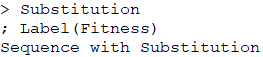

, e.g.,
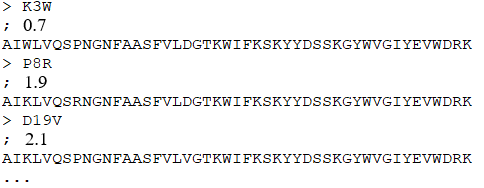

Main Execution using `run` sets output path to the current working directory. 
If learning and validation sets are given, the script runs model training and performance evaluation; the best (`-s`) models will be stored as pickle files inside the created subdirectory */Pickles*;
If validation .fasta is given with selected model, the validation is plotted using the selected model for predictions on the validation dataset.
If prediction set and selected model are given the program will perform predictions on sequences given in the prediction .fasta. 

## Running in Terminal

Before running this protocol it is advised to create a new Python 3 environment, e.g. using [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).
For this exemplary protocol we run our workflow on the ANEH set reported by [Gumulya, Sanchis, and Reetz]( https://doi.org/10.1002/cbic.201100784). For training, validating, and predicting the relative energy ($\Delta\Delta G^{\neq}$) of the ANEH variants
the tool is run following a typical machine learning approach and comprises three steps:
***
1. Learning and model validation: `python3 path/to/pypef.py run -l Learning_Set.fasta -v Validation_Set.fasta -s 10`
2. Visualization: `python3 path/to/pypef.py run -m MODEL12345 -f Validation_Set.fasta`
3. Prediction: `python3 path/to/pypef.py run -m MODEL12345 -p Prediction_Set.fasta `
***

## Exemplary running in Jupyter Notebook: Run code cells starting from here
We tested this Notebook running on [Python 3.7.9](https://www.python.org/downloads/release/python-379/).
To ensure you are using the correct environment, i.e., Python version, you can activate your conda environment (here exemplary termed pypef_environment_py37) and load the ipython kernel.

`conda activate pypef_environment_py37`

`python3 -m ipykernel install --user`

To check your current working directory, this should be inside the folder *workflow* at this point.

In [ ]:
# run this Cell first to save the script directory; here your working directory should be the folder "path/to/workflow".
# if not, change directory, e.g. using %cd or os.chdir() or run this Cell a second time:
# If you changed the current working dir, this will take you back to the workbook dir.
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('Current Working Directory: ' + workbookDir)
os.chdir(workbookDir)  
if workbookDir[-8:] != "workflow":
    try:
        os.chdir(os.getcwd().split("workflow",1)[0] + "workflow")
        print("You are here \"{}\", You should be in the workflow directory for\
        running the script when starting from here!").format(os.getcwd())
    except:
        print("You are here \"{}\", please change path to /workflow directory.".format(os.getcwd()))
else:
    print("You are in the correct directory for running the script when starting from here!")

Installing required Python modules using pip. If you don't want to change your current Python Environment, better create a new one (e.g. using Conda) and run then run the cell below.
To install parallel modules (Ray, setproctitle) on Windows, Visual C++ 14.0 is required. More on this later in the following.

In [ ]:
# Install packages in the current Jupyter kernel using pip, you can get installed packages and
# Py version with >>>print(help('modules'))
%run -m pip install --user -r ../requirements.txt

In [ ]:
%run ../src/pypef.py -h

Change directory to /test_dataset and create learning (LS) and validation (VS) datasets:

In [ ]:
%cd test_dataset/

In [ ]:
%run ../../src/pypef.py mklsvs -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa

(Also, you can test all 150 variants (`-i 150_ANEH_variants.csv` or directly use prepared LS_B.fasta and VS_B.fasta for running) but running will take much longer.) Now, LS and VS sets as .fasta text files were created in the folder.

Next, you can 
run model training and validation and saving 10 best models (using single CPU):

In [ ]:
%run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10
# same as %run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10 --regressor pls
# finally training the model on all data would be defined by: 
# %run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10 --regressor pls --all

Here, by default PLS was used as regressor and the model was tuned performing LOOCV (time intensive) and Fourier transform of the encoded sequences. You can define the regressor you want to use using the flag `--regressor {pls, pls_cv, rf, svr}` (pls_cv, rf, svr tuned with GridSearchCV) and the encoding when no FFT is desired using flag `--nofft` (likely `--nofft` better option when using RF and SVR). For the tutorial we stick to the PLS regressor.

##### <font color='red'>This 'parallel running' section may not work when running on Windows</font>

For Unix-like systems (macOS, Linux) the use of Ray (https://docs.ray.io/en/latest/index.html) is supported and for parallel running you can define the flag `--parallel` and the number of cores to be used `-c CNUMBER`. For Windows, Ray is not yet fully supported (see [Ray for Windows](https://docs.ray.io/en/latest/installation.html#windows-support) for more information). For running on Windows you may need to install the latest version of [Visual C++](https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads).

In [ ]:
%run -m pip install --user -r ../../requirements_parallelization.txt

In [ ]:
# To avoid potential system instabilities, just run parallel in Unix System
# using 4 cores for running (-c 4)
%run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10 --parallel -c 4

##### <font color='red'>Section end</font>

The output of the validation (of the entries in *Validation_Set.fasta*) is written to *Model_Result.txt* and furthermore, the 5-fold CV performance for each of the `-s TRESHOLD` models is plotted and stored in the folder *CV_performance*. Obviously, the computed $R^2$ heavily depends on the positional information content of the splitted learning and validation datasets. Note that a high number of components for a model might be a sign of overfitting; here the testing of *k*-fold datasplits might be helpful as indicator of possible overfitting (see folder *CV_performance*).
The best models are reported in the *Model_Results.txt* file; we can also show the model results using 

In [ ]:
%run ../../src/pypef.py --show

Next, one can plot the prediction on the validation dataset; e.g. for validating the predictions of the best model, i.e. index FAUJ880104 having an $R^2$ = 0.909 and an RMSE = 0.144. However, this does not mean that the identified model is the best across different splits, a good idea is also to investigate the *k*-fold CV performance of all models (folder *CV_performance*). For visualization of predictions run command cell below and see the stored *.png* image.

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta

Or, you can save a labeled plot which uses adjustText (https://github.com/Phlya/adjustText/wiki) which iteratively tries to adjust the labels of the variants (can take some time for close/crowded data points).

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta --label

The saved images should look similar to these plots (left: unlabeled, right: labeled):

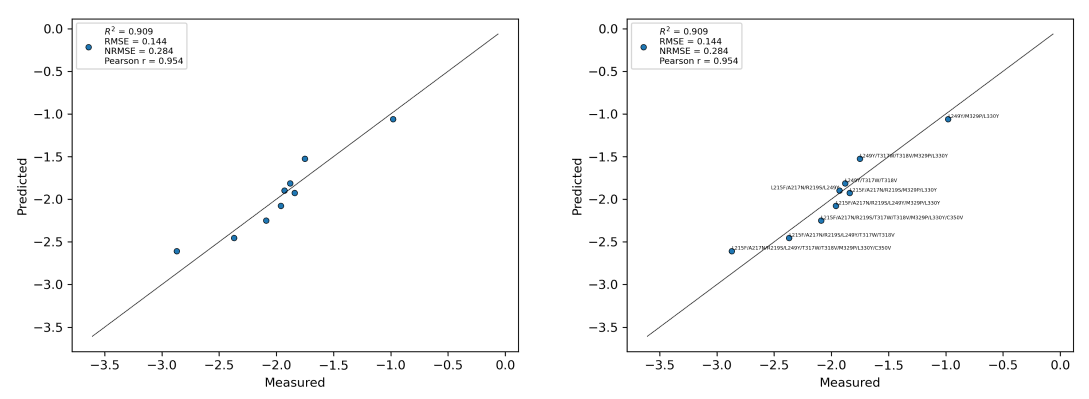


Or, to plot a colored version that divides the predicted variants in the classification categories false positive (FP, top left), true positive (TP, top right), true negative (TN, down left), false negative (FN, down right), try:

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta --color --ywt -1.5

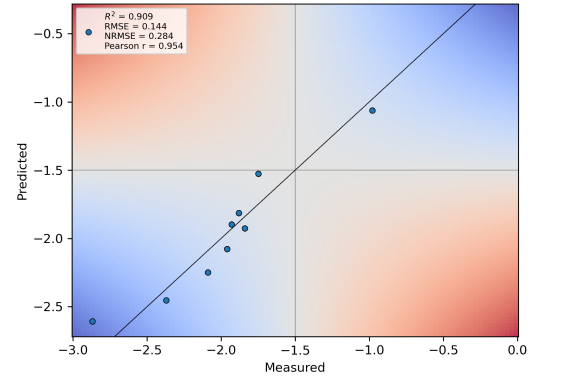


#### Making predictions
Finally, one can predict new variants of the unknown sequence space, e.g. by predicting double or triple substitutional variants with single substitutional recombinant (or full natural) diversity. For simplified prediction set generation one can use the `mkps` function.

In [ ]:
%run ../../src/pypef.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa

Now we got an error as we did not specify which recombinants we want to test. Exemplary, we can define the flag `--drecomb` and `trecomb`for establishing double and triple substitutional recombinant sequence variants; diverse sequence variants can be established using the keyword 'diverse', e.g. defining the flag `--tdiverse` (attention: diverse sets creation can take a long time and can require much hard drive space dependent on the number of single substitutional variants and sequence length):

In [ ]:
%run ../../src/pypef.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa --drecomb --trecomb --tdiverse

Recombined double and triple substitutional variants prediction sets are stored in *Recomb_Double_Split* and *Recomb_Triple_Split*. These single files can be predicted under selection of a trained model using the command `run` and defining the model and the prediction sets. `--pmult` is used to predict the files in the prediction set folders (might take a while), whereas `-p` could be used to predict a single file in the current working directory. As more negative values of ($\Delta\Delta G^{\neq}$) define better/more stable variants we order variants using the `--negative` key word:

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 --pmult --drecomb --trecomb --tdiverse --negative

The generated files (*Predictions_...**.** txt* files) contain the sorted predictions for all given variants. The best variants can be tested/validated in the lab. Keep in mind, when predicting pure recombinants, variant predictions will likely be less error-prone than natural diverse variants. Subsequently, lab-tested data can be used as further input for model improvement.

#### Alternative way of predicting: Running predictions on random *in silico* directed evolution walks

as the sequence space for predicting all diverse variants gets too vast with accumulating mutations too fast to get predicted exhaustively, one can use randomly selected substitions that will be added to the WT sequence when meeting a criterion that is defined using the Metropolis-Hastings algorithm. Therefore, the user can use the command `directevo` when defining the model `-m` to be used for predicting the explored evolution path. By default, 5 substitutions (`--numiter 5`) will be tested for each round of evolution, by default, in total 5 evolution pathways (`--numtraj 5`) will be explored. See the output .png plots for each command performed. Visible are the (5) trajectories and the introduced substitution for each trajectory as well as its corresponding fitness. Trajectories will alos be stored in two folder directorie; see output .txt files in DE_record and EvoTraj. The wild-type fitness (`-y`) is given with -1.5. Also see the Jupyter Notebook (NK_landsape.ipynb) for the investigation of the method effectivity on the [NK landscape](https://www.biorxiv.org/content/10.1101/2020.09.30.319780v3).

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -w Sequence_WT_ANEH.fa -y -1.5 --negative

The output should be somewhat similar to this plot (notice, that by definition, subsequent subtitutions of the same amino acid positions can occur):

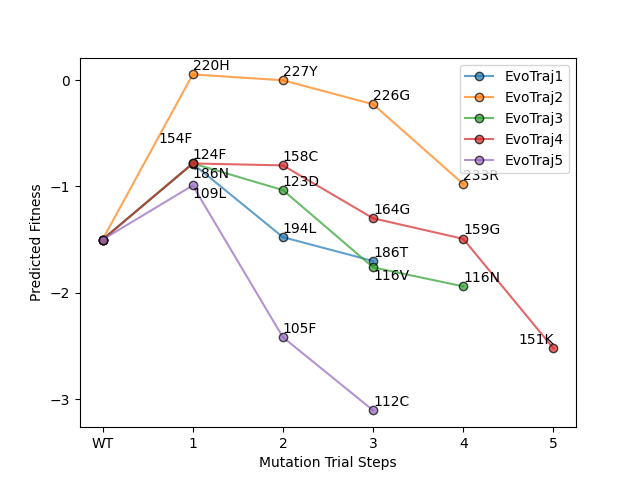

To explore deeper and/or more trajectories, one can change these parameters accordingly:

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -w Sequence_WT_ANEH.fa -y -1.5 --numiter 10 --numtraj 8 --negative

To only use the data that is provided in the csv, one can define the flags `--usecsv` for just using the positions that are given in the csv data and additionally `--csvaa` to only use the substitution amino acids that are given in the csv data. 

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa -y -1.5 --usecsv --csvaa --negative

The effect of FFT is seen for the *in silico* directed evolution drastically, this as as the model without FFT has no variance for the unknown (neighboring) substitution positions. This means that randomly chosing positions (which has very high uncertainty anyways and the recombination of positions and amino acids using `--usecsv` and `--csvaa` will have lower uncertainty) will likely have no effects on estimated substitution effects when using the `--nofft` option (more discussion and plot of impact of substitution on the feature vector is given in the Supporting Information of our paper). E.g., you can see this effect when training a "noFFT" model and subsequently running directed evolution and looking at the trajectory plot.

In [ ]:
%run ../../src/pypef.py run -l LS.fasta -v VS.fasta --nofft
%run ../../src/pypef.py --show
%run ../../src/pypef.py directevo -m WEBA780101 -w Sequence_WT_ANEH.fa -y -1.5 --negative --nofft

#### Done! End of Notebook.
If you like, you can also compare performances to the regression options RF, SVR, MLP and using the `--nofft` (and/or `--all`) option (and feel free to implement and test other regression options in your private code repository).